# Text Mining-Emotion Mining 

In [1]:
#!pip install beautifulsoup4
#!pip install requests

In [2]:
import pandas as pd
import numpy as np
import re
import string 
import spacy 
import nltk 

from matplotlib import pyplot as plt
from matplotlib.pyplot import imread
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud,STOPWORDS

from nltk import tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import CountVectorizer

import requests
from bs4 import BeautifulSoup

import warnings
warnings.filterwarnings("ignore")

In [3]:
headers = ({"User-Agent":"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/106.0.0.0 Safari/537.36"})
url = "https://www.amazon.in/Airdopes-121v2-Bluetooth-Immersive-Assistant/dp/B08JQN8DGZ/ref=cm_cr_arp_d_product_top?ie=UTF8"

In [4]:
#A function to get the contents of individual product pages using 'data-asin' number (unique identification number)
cookie={} # insert request cookies within{}
def Searchasin(asin):
    url="https://www.amazon.in/dp/"+asin
    page=requests.get(url,cookies=cookie,headers=headers)
    if page.status_code==200:
        return page
    else:
        return "Error"

In [5]:
#A function to pass on the link of 'see all reviews' and extract the content
def Searchreviews(review_link):
    url="https://www.amazon.in"+review_link
    page=requests.get(url,cookies=cookie,headers=headers)
    if page.status_code==200:
        return page
    else:
        return "Error"

In [6]:
data_asin = url.split("/dp/")[1]
data_asin =  data_asin.split("/")[0]
data_asin = [data_asin]

In [7]:
link=[]
for i in range(len(data_asin)):
    response=Searchasin(data_asin[i])
    soup=BeautifulSoup(response.content)
    for i in soup.findAll("a",{'data-hook':"see-all-reviews-link-foot"}):# the tag which is common for all products
        link.append(i['href'])

In [8]:
pages=500
for j in range(1):
    for k in range(pages):
        response=Searchreviews(link[j]+'&pageNumber='+str(k))
        soup=BeautifulSoup(response.content)

In [9]:
reviews=[]
for j in range(1):
    for k in range(pages):
        response=Searchreviews(link[j]+'&pageNumber='+str(k))
        soup=BeautifulSoup(response.content)
        for i in soup.findAll("span",{'data-hook':"review-body"}):
            reviews.append(i.text)

In [10]:
review=[]
for i in range(0,len(reviews)):
    review.append(reviews[i])
review[:]=[rev.lstrip('\n') for rev in review]
review[:]=[rev.rstrip('\n') for rev in review]

In [11]:
print(len(review))
review[:5]

5000


['I bought these airdopes in oct 2021 and exactly after a year few days in oct 2022 they stopped working out of nowhere. They worked great for a year. I had no issue no problems and i took care of them too idk why it suddenly stopped working. The problem started when it stopped charging 2-3 days back and the person whom i took it to repair said that jack is gone. Although it worked amazing for me for a year but then also only one issue was that on call the receiver was not able to hear my voice properly and even if i send voice chats. Overall I didn’t expect it to stop working like this. Short life span maybe! Hope it helps if someone is willing to buy!',
 'I got this during Amazon Great Indian festival for 700rs and I guess its my best buy. Since you would not regret owning this which does its job on its best. Sound quality is good.. Bass is fine and Noise cancellation works fine too.Go for it only if you are looking for airdopes under budget.',
 'I am using this product with overall 

In [12]:
rev = {"text":review}
data = pd.DataFrame(rev)
# Save the output.
data.to_csv("/review.csv")

In [13]:
reviews = pd.read_csv("/review.csv", encoding = "Latin-1")
reviews.drop(['Unnamed: 0'],inplace = True, axis = 1)
reviews.head()

,text
0,I bought these airdopes in oct 2021 and exactl...
1,I got this during Amazon Great Indian festival...
2,I am using this product with overall good soun...
3,Its a pretty cool product very fast delivery a...
4,Display was not work perfectly ð But this it...


### Text Pre-Processing 

In [14]:
reviews["text"] = reviews["text"].astype("str")
reviews = [text.strip() for text in reviews.text] # remove both the leading and the trailing characters(empty/white space)
reviews = [text for text in reviews if text] # removes empty strings, because they are considered in Python as False
ttext = " ".join(reviews)# Joining the list into one string/text

### Wordcloud

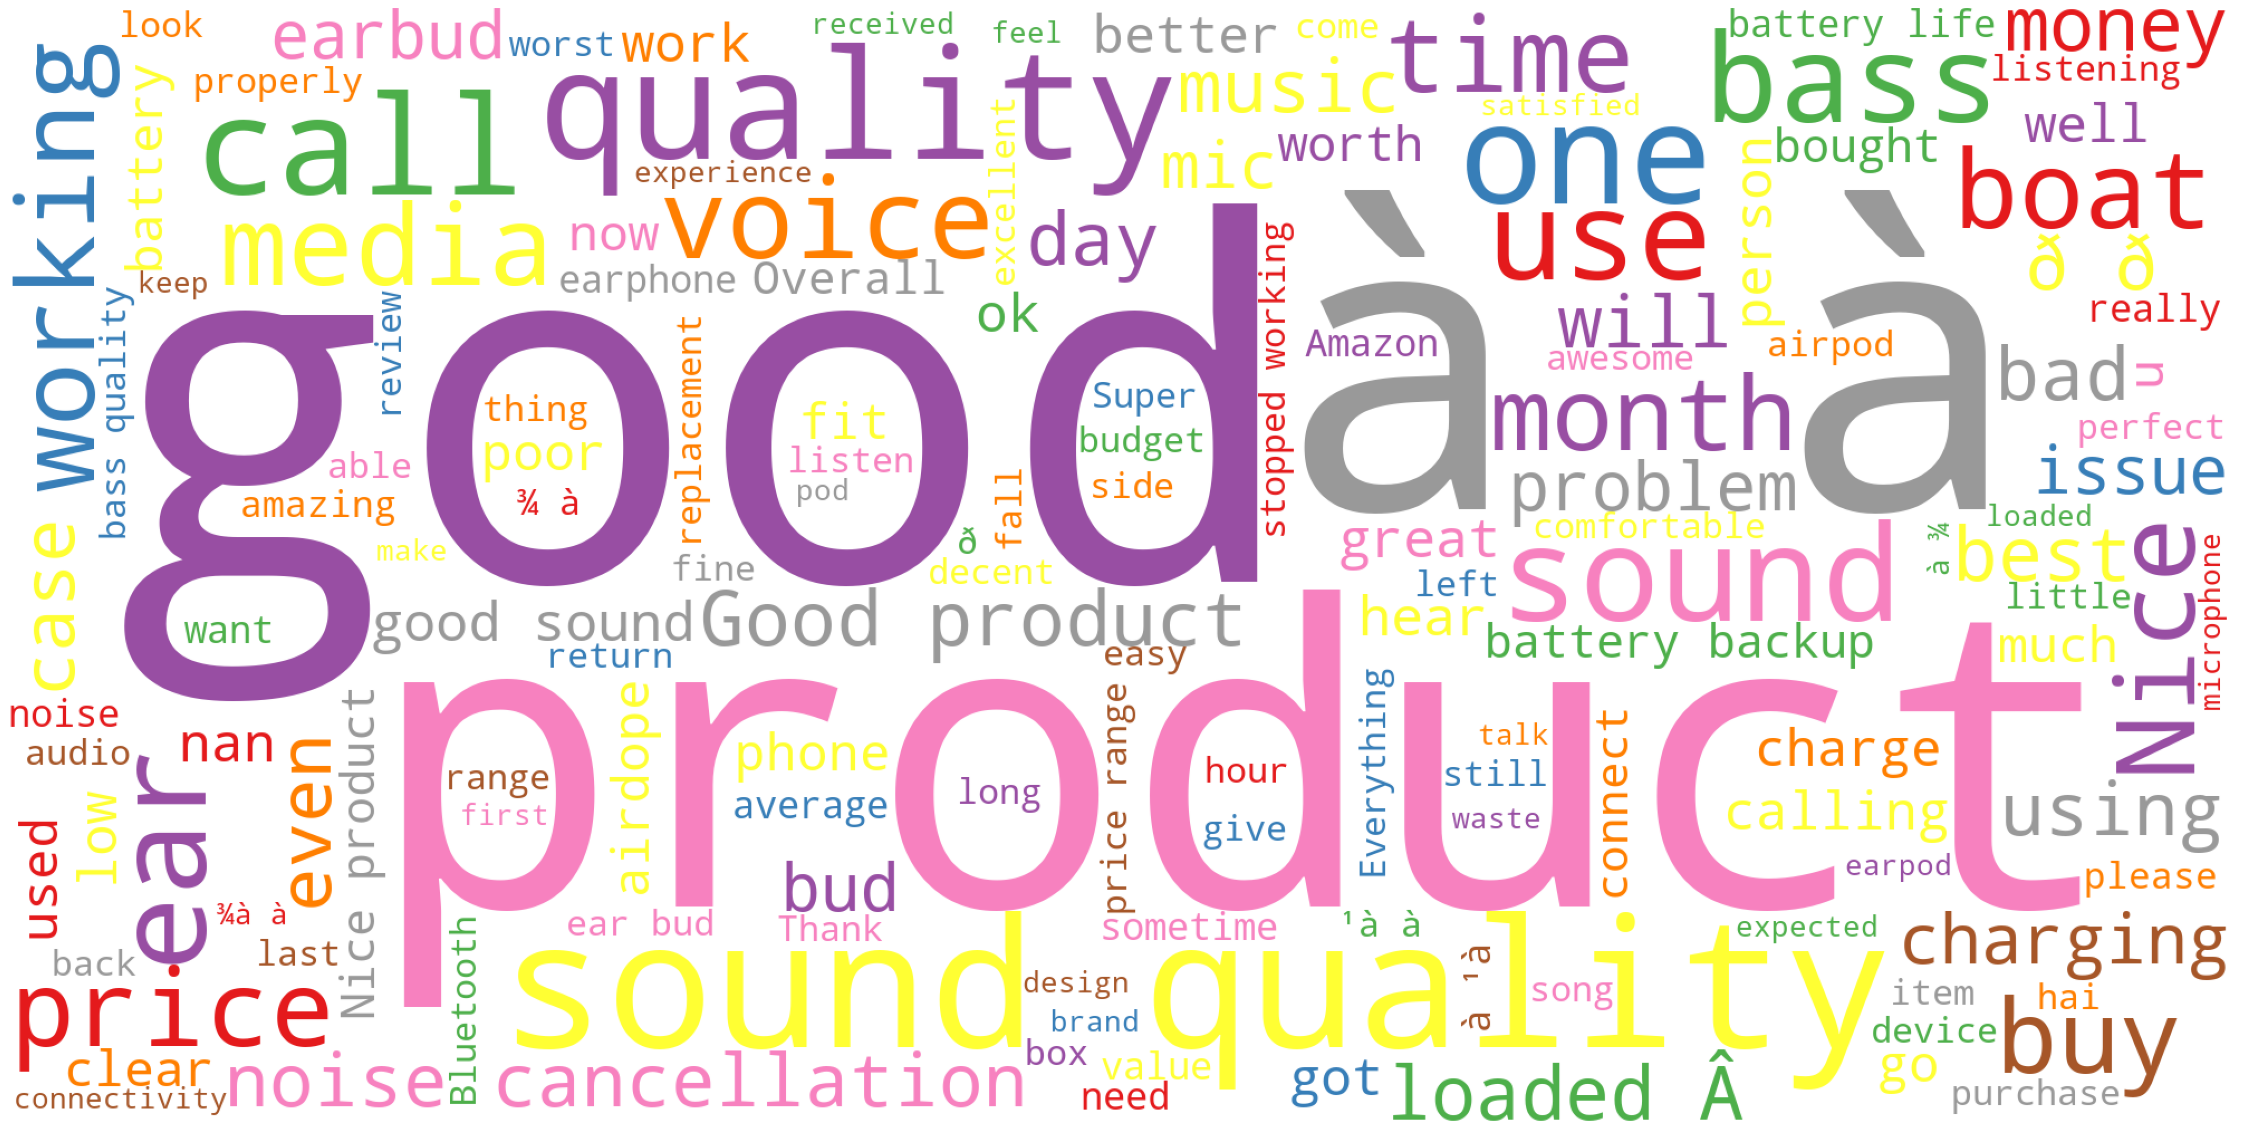

In [15]:
# Define a function to plot word cloud
def plot_cloud(wordcloud):
    plt.figure(figsize=(40, 25))
    plt.imshow(wordcloud)  
    plt.axis("off");
    
# Generate & plot wordcloud
stopwords = STOPWORDS
wordcloud=WordCloud(width=2000,height=1000,background_color="white",max_words=150,
                    colormap="Set1",stopwords=stopwords).generate(ttext)
plot_cloud(wordcloud)

### Name Entity Recognition
### Entity Tagging

In [16]:
nlp = spacy.load("en_core_web_sm")
one_block = ttext
doc_block = nlp(one_block)

### Parts of Speech Tagging

In [17]:
for token in doc_block[0:20]:
    print(token,"-", token.pos_)

I - PRON
bought - VERB
these - DET
airdopes - NOUN
in - ADP
oct - PROPN
2021 - NUM
and - CCONJ
exactly - ADV
after - ADP
a - DET
year - NOUN
few - ADJ
days - NOUN
in - ADP
oct - PROPN
2022 - NUM
they - PRON
stopped - VERB
working - VERB


In [18]:
#Filtering for nouns and verbs only
nouns_verbs = [token.text for token in doc_block if token.pos_ in ("NOUN","VERB")]
print(nouns_verbs[0:25])

['bought', 'airdopes', 'year', 'days', 'stopped', 'working', 'worked', 'year', 'had', 'issue', 'problems', 'took', 'care', 'idk', 'stopped', 'working', 'problem', 'started', 'stopped', 'charging', 'days', 'person', 'took', 'repair', 'said']


In [19]:
#Counting tokens again
cv = CountVectorizer()
X = cv.fit_transform(nouns_verbs)
sum_words = X.sum(axis=0)
words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
wf_df = pd.DataFrame(words_freq)
wf_df.columns = ["word", "count"]
print(len(wf_df))
wf_df[0:10]

3313


,word,count
0,product,1476
1,quality,1439
2,sound,643
3,working,468
4,battery,432
5,price,357
6,bass,352
7,use,350
8,ear,339
9,voice,338


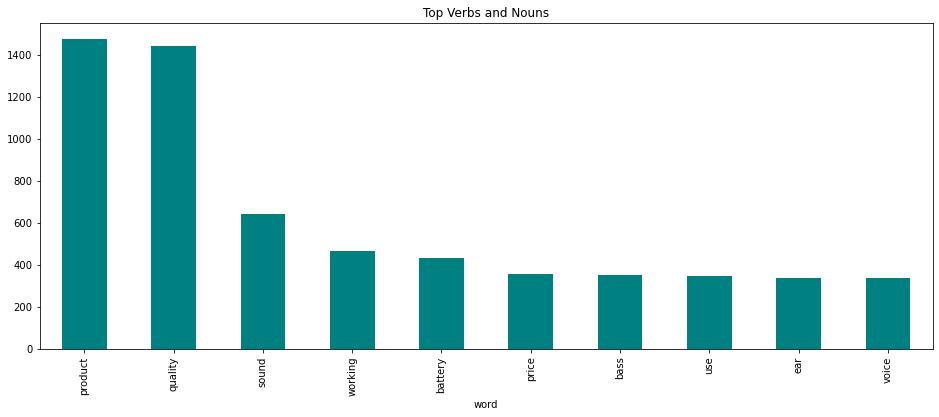

In [20]:
#Barchart for top 10 nouns + verbs
wf_df[0:10].plot.bar(x="word",figsize=(16,6),legend=False,title="Top Verbs and Nouns",color="teal");

### Sentimental Analysis

In [21]:
#tokenize into sentences
sentences = tokenize.sent_tokenize(" ".join(reviews))
sentences[0:5]

['I bought these airdopes in oct 2021 and exactly after a year few days in oct 2022 they stopped working out of nowhere.',
 'They worked great for a year.',
 'I had no issue no problems and i took care of them too idk why it suddenly stopped working.',
 'The problem started when it stopped charging 2-3 days back and the person whom i took it to repair said that jack is gone.',
 'Although it worked amazing for me for a year but then also only one issue was that on call the receiver was not able to hear my voice properly and even if i send voice chats.']

In [22]:
#review to individual sentences
sent_df = pd.DataFrame(sentences, columns=["sentence"])
sent_df

,sentence
0,I bought these airdopes in oct 2021 and exactl...
1,They worked great for a year.
2,I had no issue no problems and i took care of ...
3,The problem started when it stopped charging 2...
4,Although it worked amazing for me for a year b...
...,...
4481,Audio quality is average.
4482,Unable to get clarity with phone calls If you ...
4483,Great sound quality Good sound ..solid battery...
4484,Should also work on the casing of the headphon...


**Using Given file lexicons**

In [23]:
#loading positive and negative words file
positive=pd.read_csv("/positive.txt",sep=" ",header=None,names=["words"])
negative= pd.read_csv("/negative.txt", encoding = "Latin-1",sep=" ",header=None,names=["words"])
print("Postive-",positive.shape,", Negative-",negative.shape)

Postive- (2006, 1) , Negative- (4783, 1)


In [24]:
stemmer = PorterStemmer()

#preprocess function 
stem_words=lambda x: stemmer.stem(x)
break_into_words = lambda x : re.findall("[a-zA-Z0-9]+", x)
skip_numeric = lambda x : [w for w in x if not w.isnumeric()]

#apply pre-processing steps
processed_text=sent_df["sentence"].map(break_into_words)\
        .map(skip_numeric)
sent_df["processed"]=processed_text

In [25]:
#count number of positive words
positive_words_count=processed_text.map(lambda x: len([w for w in x if w in list(positive["words"])]))

#count number of negative words
negative_words_count=processed_text.map(lambda x: len([w for w in x if w in list(negative["words"])]))

sent_df["word_count"] = sent_df["sentence"].str.split().apply(len)
sent_df["positive"]=positive_words_count
sent_df["negative"]=negative_words_count
sent_df["sentiment_score"]=sent_df["positive"]-sent_df["negative"]

sent_df

,sentence,processed,word_count,positive,negative,sentiment_score
0,I bought these airdopes in oct 2021 and exactl...,"[I, bought, these, airdopes, in, oct, and, exa...",23,0,0,0
1,They worked great for a year.,"[They, worked, great, for, a, year]",6,2,0,2
2,I had no issue no problems and i took care of ...,"[I, had, no, issue, no, problems, and, i, took...",19,0,2,-2
3,The problem started when it stopped charging 2...,"[The, problem, started, when, it, stopped, cha...",24,0,1,-1
4,Although it worked amazing for me for a year b...,"[Although, it, worked, amazing, for, me, for, ...",36,3,1,2
...,...,...,...,...,...,...
4481,Audio quality is average.,"[Audio, quality, is, average]",4,0,0,0
4482,Unable to get clarity with phone calls If you ...,"[Unable, to, get, clarity, with, phone, calls,...",31,2,0,2
4483,Great sound quality Good sound ..solid battery...,"[Great, sound, quality, Good, sound, solid, ba...",45,5,1,4
4484,Should also work on the casing of the headphon...,"[Should, also, work, on, the, casing, of, the,...",14,1,1,0


In [26]:
# Sentiment score of the whole tweet
sent_df[["sentiment_score"]].describe()

,sentiment_score
count,4486.000000
mean,0.671422
std,1.628185
min,-6.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,13.000000


In [27]:
# Sentiment score of the review - Negative Score Filtering
sent_df[sent_df["sentiment_score"]<0].tail()

,sentence,processed,word_count,positive,negative,sentiment_score
4461,Good sound Calling problems The media could no...,"[Good, sound, Calling, problems, The, media, c...",10,0,1,-1
4463,Picks up outside noise while speaking on mic.,"[Picks, up, outside, noise, while, speaking, o...",8,0,1,-1
4469,"However I recieved a used product, there were ...","[However, I, recieved, a, used, product, there...",29,0,1,-1
4474,Noise Cancelation is worst One side dope has b...,"[Noise, Cancelation, is, worst, One, side, dop...",20,0,2,-2
4479,It kept falling off.,"[It, kept, falling, off]",4,0,1,-1


**Using Affin lexicon**

In [28]:
#Sentiment analysis
afinn = pd.read_csv("/Afinn.csv",sep=",", encoding="latin-1")
print(afinn.shape)
afinn.head()

(2477, 2)


,word,value
0,abandon,-2
1,abandoned,-2
2,abandons,-2
3,abducted,-2
4,abduction,-2


In [29]:
#creating a dictionary for affin scores
affinity_scores = afinn.set_index("word")["value"].to_dict()

In [30]:
#Custom function :score each word in a sentence in lemmatised form,but calculate the score for the whole original sentence.
nlp = spacy.load("en_core_web_sm")
sentiment_lexicon = affinity_scores
# user defined function to calculate aggregate scores
def calculate_sentiment(text: str = None):
    sent_score = 0
    if text:
        sentence = nlp(text)
        for word in sentence:
            sent_score += sentiment_lexicon.get(word.lemma_, 0)
    return sent_score

In [31]:
#sentiment on whole text
sent_df["A_sentiment_value"] = sent_df["sentence"].apply(calculate_sentiment)
sent_df.head()

,sentence,processed,word_count,positive,negative,sentiment_score,A_sentiment_value
0,I bought these airdopes in oct 2021 and exactl...,"[I, bought, these, airdopes, in, oct, and, exa...",23,0,0,0,-1
1,They worked great for a year.,"[They, worked, great, for, a, year]",6,2,0,2,3
2,I had no issue no problems and i took care of ...,"[I, had, no, issue, no, problems, and, i, took...",19,0,2,-2,-3
3,The problem started when it stopped charging 2...,"[The, problem, started, when, it, stopped, cha...",24,0,1,-1,-3
4,Although it worked amazing for me for a year b...,"[Although, it, worked, amazing, for, me, for, ...",36,3,1,2,4


In [32]:
# Sentiment score of the whole tweet
sent_df[["A_sentiment_value"]].describe()

,A_sentiment_value
count,4486.000000
mean,2.377842
std,4.445748
min,-12.000000
25%,0.000000
50%,1.000000
75%,3.000000
max,32.000000


In [33]:
# Sentiment score of the review - Negative Score Filtering
sent_df[sent_df["A_sentiment_value"]<0].tail()

,sentence,processed,word_count,positive,negative,sentiment_score,A_sentiment_value
4441,The replaced ones came but it has the same pro...,"[The, replaced, ones, came, but, it, has, the,...",26,0,1,-1,-2
4449,Â Sound quality is pathetic ..thats the reason...,"[Sound, quality, is, pathetic, thats, the, rea...",15,0,1,-1,-2
4452,Good Totally disappointed and returned the pro...,"[Good, Totally, disappointed, and, returned, t...",7,0,1,-1,-2
4458,Ok Some time other is not able hear The produc...,"[Ok, Some, time, other, is, not, able, hear, T...",37,1,2,-1,-5
4474,Noise Cancelation is worst One side dope has b...,"[Noise, Cancelation, is, worst, One, side, dop...",20,0,2,-2,-4


In [34]:
sent_df["index"]=range(0,len(sent_df))

**Comparision of both lexicons**

In [35]:
# Sentiment score of the whole tweet
sent_df[["A_sentiment_value","sentiment_score"]].describe()

,A_sentiment_value,sentiment_score
count,4486.000000,4486.000000
mean,2.377842,0.671422
std,4.445748,1.628185
min,-12.000000,-6.000000
25%,0.000000,0.000000
50%,1.000000,0.000000
75%,3.000000,1.000000
max,32.000000,13.000000


### Visualization

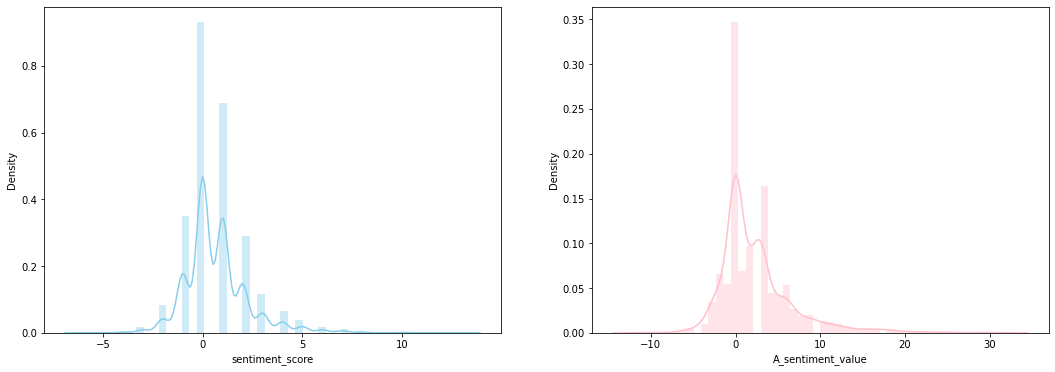

In [36]:
fig = plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
sns.distplot(sent_df["sentiment_score"],color="skyblue")

plt.subplot(1,2,2)
sns.distplot(sent_df["A_sentiment_value"],color="pink");

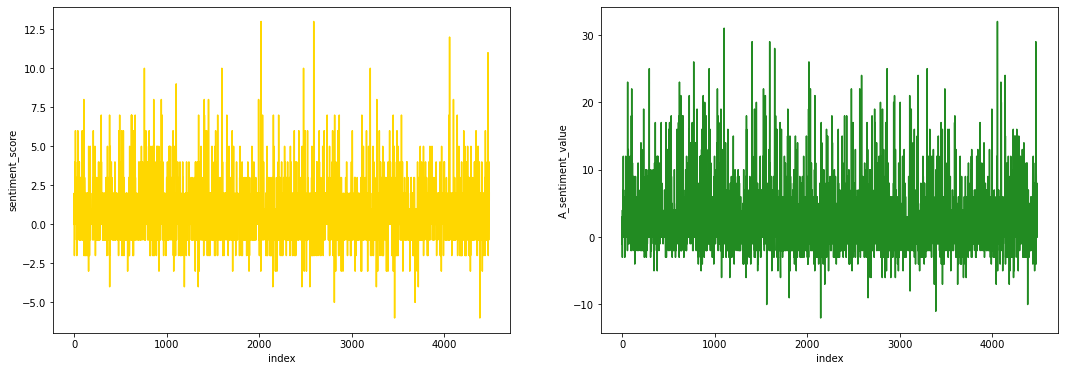

In [37]:
fig = plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
sns.lineplot(y="sentiment_score",x="index",data=sent_df,color="gold")

plt.subplot(1,2,2)
sns.lineplot(y="A_sentiment_value",x="index",data=sent_df,color="forestgreen");

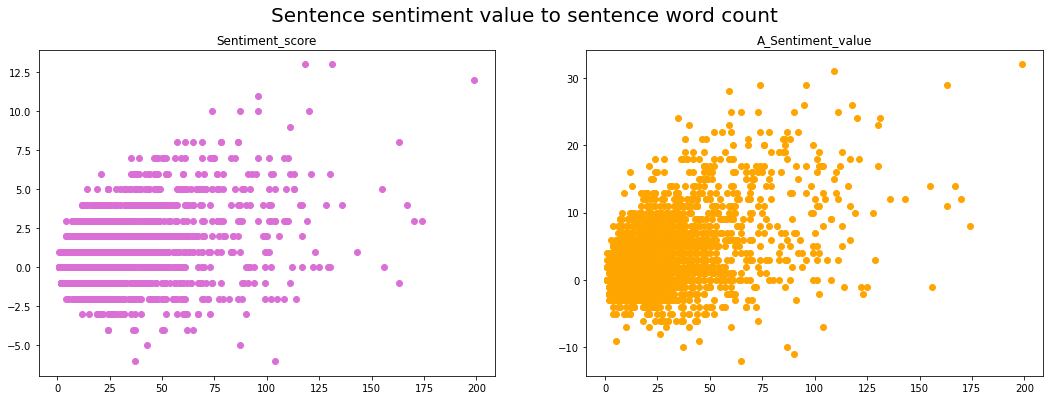

In [38]:
fig = plt.figure(figsize=(18,6))
plt.suptitle("Sentence sentiment value to sentence word count", size=20, y=0.98)

plt.subplot(1,2,1)
plt.scatter(x="word_count",y="sentiment_score",data=sent_df,color="orchid")
plt.title("Sentiment_score")

plt.subplot(1,2,2)
plt.scatter(x="word_count",y="A_sentiment_value",data=sent_df,color="orange")
plt.title("A_Sentiment_value");

**It can be seen that both lexicon are different and can bring a vast difference in text mining**